In [1]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('../')
from lib.syllog_model import SyllogPyroModel
from factors.pyro import factors as PyroFactors

In [2]:
with open('data/icecream.json', 'r') as jsonfile:
    cyjson=jsonfile.read().replace('\n', '')

In [3]:
model = SyllogPyroModel.from_cyjson(cyjson)

In [4]:
# model.plot_graph('icecream2.png')

In [5]:
model.get_factor_descriptions()

{'e3569ca5-8299-4345-b2b6-3ec913d21b52': {'fn': 'Bernoulli',
  'inputs': ['p'],
  'outputs': ['x']},
 '29dd4398-b5d8-400c-af92-f2e4655e2ae1': {'fn': 'CategoricalOutcome',
  'inputs': ['outcome_mat', 'category'],
  'outputs': ['c']},
 '9b4558a1-a573-4fc2-a047-02ee71144f80': {'fn': 'CategoricalOutcome',
  'inputs': ['outcome_mat', 'category'],
  'outputs': ['c']},
 '9d097c1f-febd-4e0c-a784-ebb173800bbb': {'fn': 'Normal',
  'inputs': ['mu', 'sigma'],
  'outputs': ['z']}}

In [6]:
model.get_evidence_nodes()

['cloud_prob', 'temp_mean_mat', 'temp_variance_mat']

In [7]:
factors = {
    desc['fn']: getattr(PyroFactors, desc['fn']) 
    for desc 
    in model.get_factor_descriptions().values()
}

In [8]:
factors

{'Bernoulli': <function factors.pyro.factors.Bernoulli(_name, p)>,
 'CategoricalOutcome': <function factors.pyro.factors.CategoricalOutcome(_name, outcome_mat, category)>,
 'Normal': <function factors.pyro.factors.Normal(_name, mu, sigma)>}

In [9]:
evidence = {'temp_mean_mat': [75, 55], 'temp_variance_mat': [10,15], 'cloud_prob': 0.3}

In [12]:
samples = [model(evidence, factors)['temperature'] for i in range(1000)]

In [14]:
!pip install matplotlib

    100% |████████████████████████████████| 12.9MB 684kB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 1.2MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 2.3MB/s eta 0:00:01
mkl-random 1.0.1 requires cython, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


(array([ 1.,  0.,  2.,  1.,  2.,  1.,  5.,  4.,  5., 12.,  7.,  9.,  8.,
         6., 15., 10., 17., 22., 18., 29., 23., 41., 27., 36., 48., 51.,
        56., 74., 52., 61., 60., 69., 54., 40., 27., 23., 31., 22., 13.,
         8.,  2.,  3.,  0.,  1.,  2.,  1.,  0.,  0.,  0.,  1.]),
 array([ 15.178764,  17.198591,  19.21842 ,  21.238247,  23.258076,
         25.277903,  27.297731,  29.317558,  31.337387,  33.357212,
         35.37704 ,  37.39687 ,  39.4167  ,  41.436523,  43.456352,
         45.47618 ,  47.49601 ,  49.515835,  51.535664,  53.555492,
         55.575317,  57.595146,  59.614975,  61.634804,  63.65463 ,
         65.67445 ,  67.69428 ,  69.71411 ,  71.73394 ,  73.75377 ,
         75.7736  ,  77.79343 ,  79.813255,  81.83308 ,  83.852905,
         85.872734,  87.89256 ,  89.91239 ,  91.93222 ,  93.95205 ,
         95.97187 ,  97.9917  , 100.01153 , 102.03136 , 104.051186,
        106.071014, 108.09084 , 110.110664, 112.13049 , 114.15032 ,
        116.17015 ], dtype=float32),

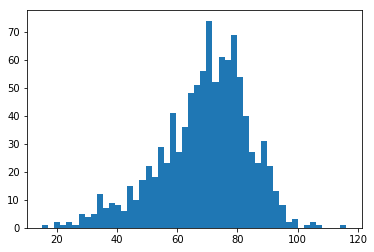

In [16]:
plt.hist(samples, bins=50)